In [706]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
from scipy import signal
from operator import attrgetter
from functools import reduce
import random

GRAY_CONVERTER = np.array([0.2989, 0.5870, 0.1140])
EPSILON = np.finfo(float).eps

train_path = r'.\Group_1\train'
test_path = r'.\Group_1\test'


In [707]:
def relu(x):
    return np.where(x >= 0, x, 0)

def leaky_relu(x, alpha=0.3):
    return np.where(x >= 0, x, alpha * x)


def sigmoid(x):
    return np.apply_along_axis(lambda a: 1 / (1 + np.exp(-a)), 0, x)


def convert_to_gray(image):
    return np.dot(image[..., :3], GRAY_CONVERTER)


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


In [708]:
class ConvolutionLayer:
    def __init__(self, H2=2, W2=2, D2=1, K=1):
        self.H2 = H2
        self.W2 = W2
        self.D2 = D2
        self.K = K
        self.filters = np.random.normal(scale=(1.0 / np.sqrt(K * H2 * W2 * D2)), size=(K, H2, W2, D2)) / (H2 * W2 * D2)
        self.bias = np.zeros(shape=(K, ))

    def iterate_regions(self, input):
        '''

        Generates overlapping (H2 x W2) size patches on the input images to perform the convolution operation with

        '''

        H1, W1, _ = input.shape

        H2, W2, D2 = attrgetter('H2', 'W2', 'D2')(self)

        for i in range(H1 - H2 + 1):
            for j in range(W1 - W2 + 1):
                section = input[i: i + H2, j: j + W2]
                yield section, i, j

    def forward(self, input):
        '''

        Returns a 3-d numpy array which is output of the convolution operation performed on the 
        input image with the created filters

        '''

        H1, W1, _ = input.shape

        self.last_input = input

        H2, W2, D2, K, filters, bias = attrgetter(
            'H2', 'W2', 'D2', 'K', 'filters', 'bias')(self)

        feature_maps = np.zeros(((H1 - H2 + 1), (W1 - W2 + 1), K))

        for section, i, j in self.iterate_regions(input):
            feature_maps[i, j] += np.sum(section
                                         * filters, axis=(1, 2, 3))

        feature_maps += bias
        self.last_output = feature_maps

        return feature_maps

    def backprop(self, d_L_d_out, eta):
        '''
        
        Returns the gradient of the convolution layer for backpropagation

        '''
        d_L_d_out = np.where(self.last_output < 0, 0, d_L_d_out)
        
        H2, W2, D2, K, filters, bias = attrgetter(
            'H2', 'W2', 'D2', 'K', 'filters', 'bias')(self)

        d_L_d_filters = np.zeros(self.filters.shape)
        d_L_d_input = np.zeros(self.last_input.shape)

        
        for section, i, j in self.iterate_regions(self.last_input):
            for k in range(self.K):
                d_L_d_filters[k] += d_L_d_out[i, j, k] * section

        rev_filters = np.swapaxes(filters[:, ::-1, ::-1, :], 0, 3)

        
        npad = ((2, 2), (2, 2), (0, 0))
        padded_gradient = np.pad(d_L_d_out, pad_width=npad, mode='constant', constant_values=0)

        
        for section, i, j in self.iterate_regions(padded_gradient):
            d_L_d_input[i, j] += np.sum(section * rev_filters, axis=(1, 2, 3))

        
        self.filters -= eta * d_L_d_filters
        self.bias -= eta * np.sum(d_L_d_out, axis=(0, 1))

        return d_L_d_input


In [709]:
class PoolingLayer:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def iterate_regions(self, image):
        '''

        Generates non-overlapping pool_sizexpool_size image regions to pool over.

        '''
        size = attrgetter('pool_size')(self)
        h, w, _ = image.shape
        new_h = h // size
        new_w = w // size

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * size):(i * size + size),
                                  (j * size):(j * size + size)]
                yield im_region, i, j

    def forward(self, input):
        '''

        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)

        '''
        size = attrgetter('pool_size')(self)
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // size, w // size, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        '''

        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.

        '''
        size = attrgetter('pool_size')(self)
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * size + i2, j * size +
                                        j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input


In [710]:
class SoftmaxLayer:
    def __init__(self, n_classes, input_size):
        self.weights = np.random.normal(scale=(1.0 / np.sqrt(input_size * n_classes)),size=(input_size, n_classes)) / input_size
        self.biases = np.zeros(shape=(n_classes, ))

    def forward(self, input):
        '''

        Returns the probability values for the classes.
        - input can be any array with any dimensions.
        
        '''
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals - np.amax(totals))
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, eta):
        '''
        
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - eta is a float.
        
        '''

        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            t_exp = np.exp(self.last_totals - np.amax(self.last_totals))

            S = np.sum(t_exp)

            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            d_L_d_t = gradient * d_out_d_t

            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t
            

            self.weights -= eta * d_L_d_w
            self.biases -= eta * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape)


In [711]:
conv1_layer = ConvolutionLayer(3, 3, 3, 32)
conv2_layer = ConvolutionLayer(3, 3, 32, 64)
pool_layer = PoolingLayer(2)
# softmax_layer = SoftmaxLayer(3, 15 * 15 * 32)
softmax_layer = SoftmaxLayer(3, 14 * 14 * 64)

In [712]:
def apply(image, label):
    out = relu(conv1_layer.forward(image))
    out = relu(conv2_layer.forward(out))
    out = pool_layer.forward(out)
    out = softmax_layer.forward(out)

    
    loss = -np.log(out[label] + EPSILON)
    acc = 1 if np.argmax(out) == label else 0
    return out, loss, acc


In [713]:
def train(image, label, eta=0.005):
    out, loss, acc = apply(image, label)
    gradient = np.zeros(3)
    gradient[label] = -1 / (out[label] + EPSILON)
    gradient = softmax_layer.backprop(gradient, eta)
    gradient = pool_layer.backprop(gradient)
    gradient = conv2_layer.backprop(gradient, eta)
    gradient = conv1_layer.backprop(gradient, eta)

    return loss, acc


In [714]:
images = []
for label, item in enumerate(['bird', 'deer', 'truck']):  
    path = os.path.join(train_path, item)
    images += map(lambda img: (matplotlib.image.imread(os.path.join(path, img)) / 255.0, label),os.listdir(path)[:100])

random.shuffle(images)

In [715]:
test_images = []
for label, item in enumerate(['bird', 'deer', 'truck']):  
    path = os.path.join(test_path, item)
    test_images += map(lambda img: (matplotlib.image.imread(os.path.join(path, img)) / 255.0, label),os.listdir(path)[:10])

random.shuffle(test_images)

In [716]:
true_val, total_loss = 0, 0

for epoch in range(1):
    random.shuffle(images)
    for i, (img, label) in enumerate(images):
        loss, acc = train(img, label, 0.001)
        if i % 100 == 99:
            print('100 images processed')
        

100 images processed
100 images processed
100 images processed


In [717]:
true_val, total_loss = 0, 0


for i, (img, label) in enumerate(test_images):
    out, loss, acc = apply(img, label)
    true_val += acc
    total_loss += loss
    print('[Step %d]: Average Loss %.3f | Accuracy: %d%%' %
            (i + 1, total_loss / (i + 1), true_val * 100 / (i + 1)))
        

[Step 1]: Average Loss 1.099 | Accuracy: 0%
[Step 2]: Average Loss 1.099 | Accuracy: 0%
[Step 3]: Average Loss 1.099 | Accuracy: 33%
[Step 4]: Average Loss 1.099 | Accuracy: 50%
[Step 5]: Average Loss 1.099 | Accuracy: 40%
[Step 6]: Average Loss 1.099 | Accuracy: 50%
[Step 7]: Average Loss 1.099 | Accuracy: 42%
[Step 8]: Average Loss 1.099 | Accuracy: 37%
[Step 9]: Average Loss 1.099 | Accuracy: 33%
[Step 10]: Average Loss 1.099 | Accuracy: 30%
[Step 11]: Average Loss 1.099 | Accuracy: 36%
[Step 12]: Average Loss 1.099 | Accuracy: 33%
[Step 13]: Average Loss 1.099 | Accuracy: 30%
[Step 14]: Average Loss 1.099 | Accuracy: 35%
[Step 15]: Average Loss 1.099 | Accuracy: 33%
[Step 16]: Average Loss 1.099 | Accuracy: 31%
[Step 17]: Average Loss 1.099 | Accuracy: 29%
[Step 18]: Average Loss 1.099 | Accuracy: 27%
[Step 19]: Average Loss 1.099 | Accuracy: 31%
[Step 20]: Average Loss 1.099 | Accuracy: 30%
[Step 21]: Average Loss 1.099 | Accuracy: 28%
[Step 22]: Average Loss 1.099 | Accuracy: 27%

In [718]:
image = matplotlib.image.imread(os.path.join(train_path, 'bird', '0000.jpg'))
out1 = relu(conv1_layer.forward(image))

Outputs for Layer 1


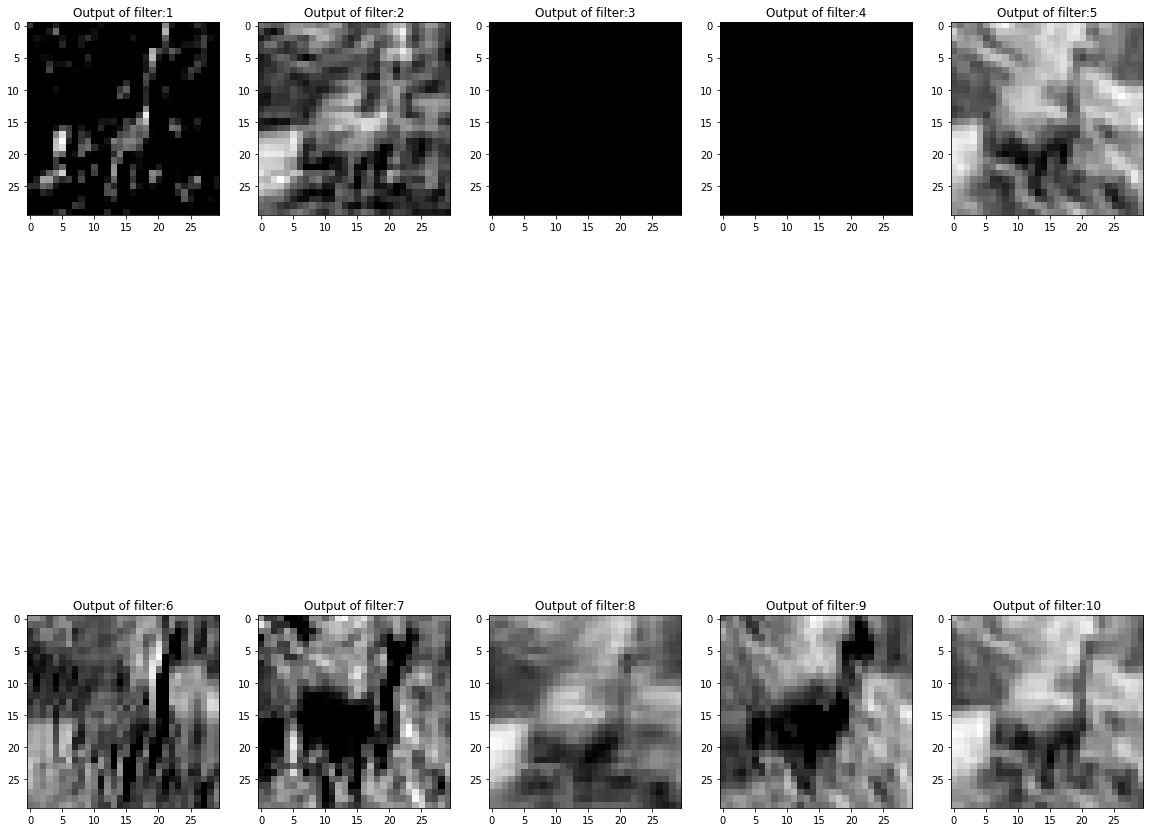

In [719]:
print("Outputs for Layer 1")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(out1[:, :, i], cmap=plt.get_cmap('gray'))
    ax.set_title('Output of filter:{}'.format(i + 1))

plt.show()


In [720]:
out2 = relu(conv2_layer.forward(out1))

Outputs for Layer 1


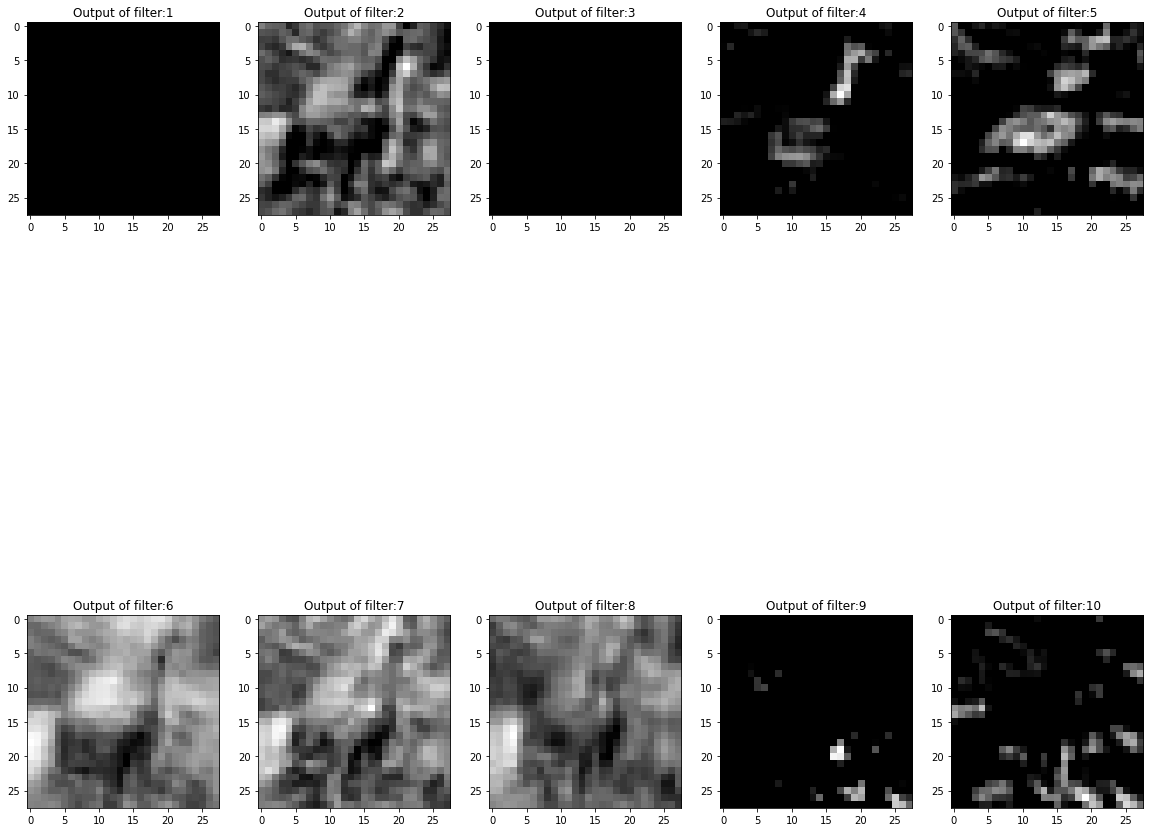

In [721]:
print("Outputs for Layer 1")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(out2[:, :, i], cmap=plt.get_cmap('gray'))
    ax.set_title('Output of filter:{}'.format(i + 1))

plt.show()


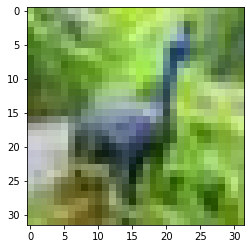

In [722]:
plt.imshow(image)
plt.show()